In [1]:
from ptycho_functions import *
from sscCdi import restoration_CAT
from sscCdi.caterete.cat_ptycho_processing import convert_probe_positions_meters_to_pixels
import numpy as np
import h5py
import cupy as cp

def rotate_coordinate_system(angle_rad,px,py):
    px_rotated = np.cos(angle_rad) * px - np.sin(angle_rad) * py
    py_rotated = np.sin(angle_rad) * px + np.cos(angle_rad) * py
    return px_rotated, py_rotated

In [2]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

In [3]:
restored_data_path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/SS03112022_02/restored_data/0000_SS03112022_02_001.npy'
restored_data = np.load(restored_data_path)

N = 1100
restored_data = restored_data[:,N:-N,N:-N]


In [15]:
""" mPIE """
if 0: # suggested min from paper
    regularization_object, regularization_probe = 0.05, 0.5
    step_object, step_probe = 0.1, 0.2
    friction_object, friction_probe = 0.5, 0.75
    momentum_counter = 10
elif 1: # suggested max from paper
    regularization_object, regularization_probe = 0.25, 5
    step_object, step_probe = 0.5, 1
    friction_object, friction_probe = 0.9, 0.99
    momentum_counter = 100 
else: # my params
    regularization_object, regularization_probe = 0.25, 5
    step_object, step_probe = 0.5, 0.1
    friction_object, friction_probe = 0.9, 0
    momentum_counter = 100 

inputs = {}
inputs['object_pixel'] = 6.574936275422776e-08 #1.9481292667919335e-08
inputs['wavelength'] = 2.0664032897701555e-10
inputs['distance'] = 14.000035595703125
inputs['iterations'] = 200
inputs["position_rotation"] = -0.003
inputs["object_padding"] = 0
inputs['centralize_probe'] = False # not implemented 
inputs['regularization_object'] = regularization_object
inputs['regularization_probe']  = regularization_probe
inputs['step_object']= step_object
inputs['step_probe'] = step_probe
inputs['use_mPIE'] = False
inputs['friction_object'] = friction_object
inputs['friction_probe'] = friction_probe
inputs['momentum_counter'] = momentum_counter
inputs['position_correction_beta'] = 0 # if 0, does not apply position correction

In [16]:
data_path = '/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/proc/recons/SS03112022_02/2023-07-17-13h23m_SS03112022_02.hdf5'
data = h5py.File(data_path,'r')

positions = data['recon/positions'][()][0][0]
# print(positions)
# probe_positions = []
# for i in range(positions.shape[0]):
#     positions_x, positions_y = rotate_coordinate_system(inputs["position_rotation"],positions[i,1], positions[i,0]) # rotate whole coordinate system (correct misalignment of scan and detector axes)
#     probe_positions.append([positions_y, positions_x])
# probe_positions = np.asarray(probe_positions).astype(np.float32) # convert list of lists to numpy array
# positions = np.rint(np.swapaxes(positions,0,1))
# print(probe_positions)
# positions = convert_probe_positions_meters_to_pixels(inputs["object_padding"],inputs["object_pixel"], probe_positions)
positions = positions.astype(np.int32)
# print(probe_positions)

obj_guess = data['recon/initial_object'][()]
probe_guess = data['recon/initial_probe'][()][0]

print(probe_guess.shape,obj_guess.shape, positions.shape)
positions

(400, 400) (682, 682) (625, 2)


array([[ 50,  50],
       [ 50,  58],
       [ 50,  65],
       ...,
       [228, 216],
       [228, 226],
       [228, 232]], dtype=int32)

In [17]:
def PIE_update_probe(iteration,probe,mPIE_params,difference, obj,positions, offset,centralize_probe = False ):          

    alpha,beta,gamma_obj,gamma_prb,_,_,_ = mPIE_params

    py, px = positions[iteration,1],  positions[iteration,0]

    obj_box = obj[py:py+offset[0],px:px+offset[1]]
    
    # if centralize_probe:
        # centralization_weight = get_circular_mask(probe.shape[0],0.1,invert=True)
        # probe = probe + gamma_prb*(difference*obj_box.conj() - centralization_weight*probe)/ ( (1-beta) *cp.abs(obj_box)**2+beta *(cp.abs(obj_box)**2).max() + centralization_weight)
    # else:
    probe = probe + gamma_prb*(difference*obj_box.conj())/ ( (1-beta) *cp.abs(obj_box)**2+beta *(cp.abs(obj_box)**2).max())

    return probe

def PIE_update_obj(mPIE_params,difference,probe,obj_box,positions,offset,position_idx,i_to_start_p_update=10,centralize_probe = False):
    
    px, py = positions[position_idx,0] ,positions[position_idx,1]
    
    alpha,beta,gamma_obj,gamma_prb,_,_,_ = mPIE_params

    obj_box = obj_box + gamma_obj*difference*probe.conj()/ ( (1-alpha)*cp.abs(probe)**2+alpha*(cp.abs(probe)**2).max() )

    return obj_box

def propagate_beam(wavefront, experiment_params,propagator='fourier'):
    
    from cupy.fft import fft2, fftshift, ifftshift, ifft2

    """ Propagate a wavefront using fresnel ou fourier propagator

    Args:
        wavefront : the wavefront to propagate
        dx : pixel spacing of the wavefront input
        wavelength : wavelength of the illumination
        distance : distance to propagate
        propagator (str, optional): 'fresenel' or 'fourier'. Defaults to 'fresnel'.

    Returns:
        output: propagated wavefront
    """    
    
    dx, wavelength,distance = experiment_params 
    
    if propagator == 'fourier':
        if distance > 0:
            output = fftshift(fft2(fftshift(wavefront)))
        else:
            output = ifftshift(ifft2(ifftshift(wavefront)))            
    
    elif propagator == 'fresnel':
    
        ysize, xsize = wavefront.shape
        x_array = cp.linspace(-xsize/2,xsize/2-1,xsize)
        y_array = cp.linspace(-ysize/2,ysize/2-1,ysize)

        fx = x_array/(xsize)
        fy = y_array/(ysize)

        FX,FY = cp.meshgrid(fx,fy)
        # Calculate approx phase distribution for each plane wave component
        w = FX**2 + FY**2 
        # Compute FFT
        F = fftshift(fft2(fftshift(wavefront)))
        # multiply by phase-shift and inverse transform 
        a = cp.exp(-1j*cp.pi*( distance*wavelength/dx**2)*w)
        output = ifftshift(ifft2(ifftshift(F*a)))

    return output

def get_brightest_diff_pattern(diffraction_patterns):
    maximums = []
    for i in range(diffraction_patterns.shape[0]):
        maximums.append(cp.max(diffraction_patterns[i]))
    idx_where_max = np.where(maximums==np.max(maximums))
    idx_where_max = cp.asarray(idx_where_max)
    return idx_where_max[0][0]

def update_exit_wave(wavefront,measurement,experiment_params,epsilon=0.01,propagator = 'fourier'):
    wave_at_detector = propagate_beam(wavefront, experiment_params,propagator=propagator)
    wave_at_detector = cp.sqrt(measurement)*wave_at_detector/(cp.abs(wave_at_detector)+epsilon)
    # wave_at_detector[measurement>=0] = (cp.sqrt(measurement)*wave_at_detector/(cp.abs(wave_at_detector)))[measurement>=0]
    updated_exit_wave = propagate_beam(wave_at_detector, (experiment_params[0],experiment_params[1],-experiment_params[2]),propagator=propagator)
    return updated_exit_wave, wave_at_detector

def mPIE_loop_cupy(diffraction_patterns, positions,object_guess,probe_guess,inputs):
    t0 = time.perf_counter()
    print("Starting PIE...")
    
    mPIE_params = (inputs['regularization_object'],inputs['regularization_probe'],inputs['step_object'],inputs['step_probe'],inputs['friction_object'],inputs['friction_probe'],inputs['momentum_counter'])
    experiment_params =  (inputs['object_pixel'], inputs['wavelength'],inputs['distance'])
    
    offset = probe_guess.shape
    
    mempool = cp.get_default_memory_pool()
    
    obj = cp.array(object_guess)
    probe = cp.array(probe_guess)
    diffraction_patterns = cp.array(diffraction_patterns)
    positions = cp.array(positions)
    
    wavefronts = cp.empty((len(diffraction_patterns),probe.shape[0],probe.shape[1]),dtype=complex)
    GBs = wavefronts.itemsize*wavefronts.size/1024/1024/1024
    print(GBs,'GBs')
    
    if inputs["use_mPIE"]:
        probeVelocity = 0
        objVelocity = 0
        T_counter = 0

    # pre_computed_numerator = cp.sum(cp.abs(diffraction_patterns[get_brightest_diff_pattern(diffraction_patterns)])**2)

    positions_history = cp.ones((inputs["iterations"],positions.shape[0],positions.shape[1]))
    if inputs['position_correction_beta'] != 0:
        betas = (beta,beta)
    
    error_list = []
    object_movie = [] # cp.empty((inputs["iterations"]*len(diffraction_patterns),obj.shape[0],obj.shape[1]),dtype=cp.complex64)
    probe_movie = []
    for j in range(inputs["iterations"]):

        if j%10 ==0 : print(f'\tIteration {j}/{inputs["iterations"]}')
        
        O_aux, P_aux = obj.copy(), probe.copy()

        obj_box_matrix = cp.zeros((len(diffraction_patterns),offset[0],offset[1]),dtype=cp.complex64)

        random_order = cp.random.permutation(len(diffraction_patterns))
        
        for counter, i in enumerate(random_order):  # loop in random order improves results!

            py, px = positions[i,1],  positions[i,0]
                        
            obj_box_matrix[i] = obj[py:py+offset[0],px:px+offset[1]]
            
            measurement = diffraction_patterns[i]
            
            """ Exit wavefiled """
            exitWave = obj[py:py+offset[0],px:px+offset[1]]*probe
        
            # if counter % 600 ==0:
            #     print(mempool.used_bytes()) 

            """ Propagate + Update + Backpropagate """
            exitWaveNew, updated_wave = update_exit_wave(exitWave,measurement,experiment_params,epsilon=0.01)

            wavefronts[i] = exitWaveNew # save to calculate iteration error in Fourier space
            
            difference = exitWaveNew - exitWave

            # if 0: 
            #     """ Power correction not working properly! See: Further improvements to the ptychographic iterative engine: supplementary material """
            #     probe = probe_power_correction(probe,diffraction_patterns.shape, pre_computed_numerator)

            obj[py:py+offset[0],px:px+offset[1]] = PIE_update_obj(mPIE_params,difference,probe.copy(),obj_box_matrix[i],positions,offset,i)
            probe = PIE_update_probe(i,probe,mPIE_params,difference,obj,positions, offset, centralize_probe = inputs['centralize_probe'])  
            
            # probe = probe*cp.asarray(get_circular_mask(probe.shape[0],0.6)) # support
            
            # object_movie.append(obj) # CAREFUL! TOO MUCH MEMORY!
            # probe_movie.append(probe)
            
            if inputs['position_correction_beta'] != 0:
                new_positions = position_correction2(i,updated_wave,measurement,obj,probe,px,py,offset,betas,experiment_params)
                positions[i,1],  positions[i,0] = new_positions

        if inputs["use_mPIE"] == True: # momentum addition
            T_counter,objVelocity,probeVelocity,O_aux,P_aux,obj,probe = momentum_addition(T_counter,mPIE_params[6],probeVelocity,objVelocity,O_aux,P_aux,obj, probe,mPIE_params[4],mPIE_params[5])

        if inputs['position_correction_beta'] != 0:
            positions_history[j] = positions
            beta_x, beta_y = update_beta(shifts_array[:,0],new_shifts_array[:,0], beta_x), update_beta(shifts_array[:,1],new_shifts_array[:,1], bet--a_y)
            print("New betas: ",beta_x, beta_y)
            shifts_array = new_shifts_array
        
        if 'model_obj' in inputs:
            error_list.append(calculate_recon_error(inputs['model_obj'],obj)) #absolute error
        else:
            error_list.append(calculate_recon_error_Fspace(diffraction_patterns,wavefronts,experiment_params)) 

    # probe = probe.get() # get from cupy to numpy
    # obj = obj.get()
    
    # cp.save('recon/object.npy',cp.asarray(object_movie))
    # cp.save('recon/probe.npy',cp.asarray(probe_movie))

    return obj.get(), probe.get(), positions.get(), error_list, time.perf_counter() - t0, positions_history

t1 = time.time()
PIE_obj, PIE_probe, PIE_positions, PIE_error, PIE_time, positions_story = mPIE_loop_cupy(restored_data, positions.copy(),obj_guess.copy(),probe_guess.copy(), inputs)
print(f'elapsed: {(time.time()-t1)/60}')

Starting PIE...
1.4901161193847656 GBs
	Iteration 0/200
	Iteration 10/200
	Iteration 20/200
	Iteration 30/200
	Iteration 40/200
	Iteration 50/200
	Iteration 60/200
	Iteration 70/200
	Iteration 80/200
	Iteration 90/200
	Iteration 100/200
	Iteration 110/200
	Iteration 120/200
	Iteration 130/200
	Iteration 140/200
	Iteration 150/200
	Iteration 160/200
	Iteration 170/200
	Iteration 180/200
	Iteration 190/200
elapsed: 5.9936202963193255


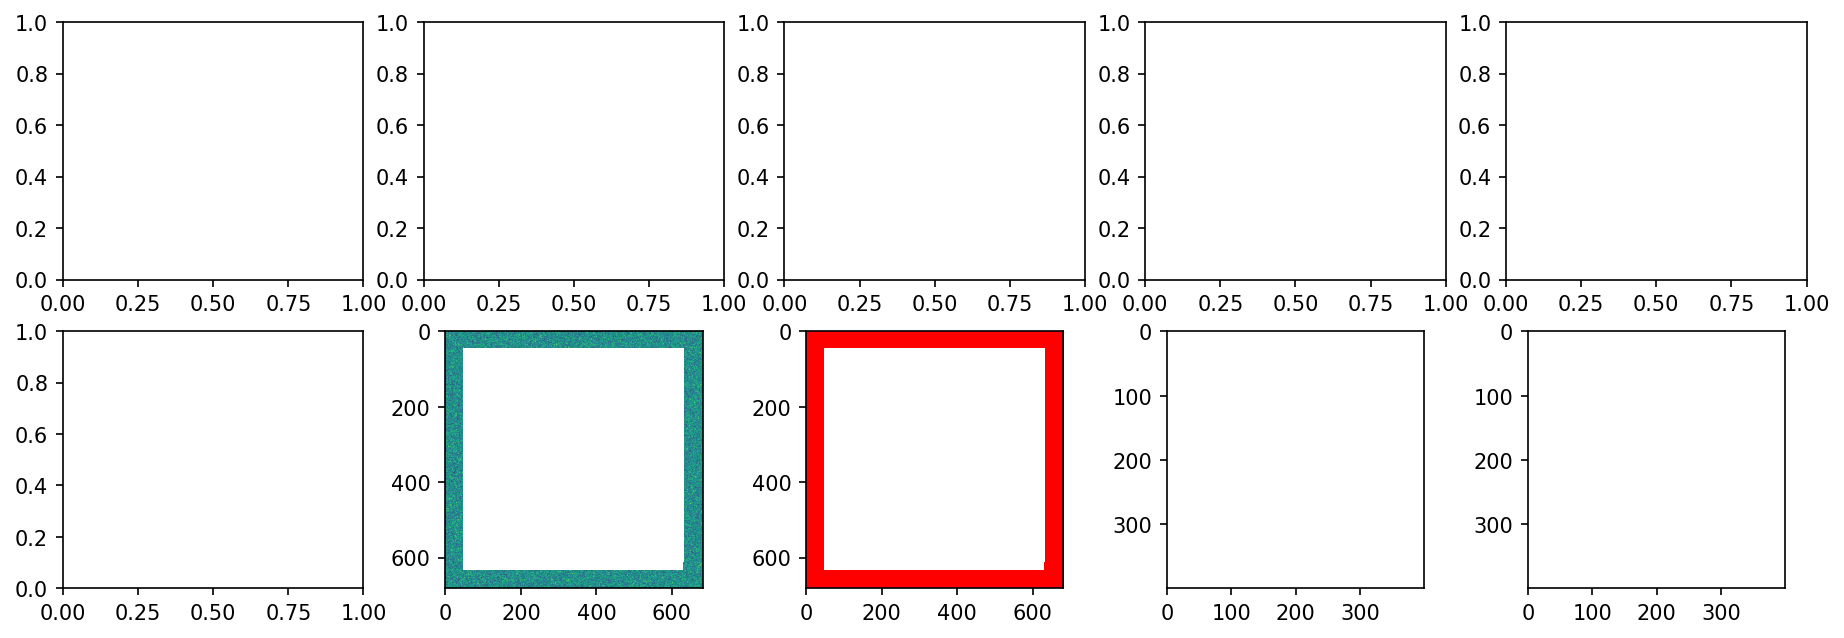

In [14]:
PIE_obj.shape, PIE_probe.shape

colormap = 'viridis'
colormap2 = 'hsv'   

figure, ax = plt.subplots(2,5,dpi=150,figsize=(15,5))
ax[1,1].imshow(np.abs(PIE_obj),cmap=colormap)
ax[1,2].imshow(np.angle(PIE_obj),cmap=colormap2)
ax[1,3].imshow(np.abs(PIE_probe),cmap=colormap)
ax[1,4].imshow(np.angle(PIE_probe),cmap=colormap2)

In [7]:
# plot_results4(diffraction_patterns,model_obj,model_probe,RAAR_obj, RAAR_probe, RAAR_error, RAAR2_obj, RAAR2_probe, RAAR2_error, RAAR2_time, axis=True )

# def plot_results4(difpads, model_obj,probe,RAAR_obj, RAAR_probe, RAAR_error, RAAR2_obj, RAAR2_probe, RAAR2_error ,RAAR2_time,axis=False):
#     colormap = 'viridis'
#     colormap2 = 'hsv'    
#     figure, ax = plt.subplots(3,5,dpi=150,figsize=(15,5))
    
#     if axis == False: # remove ticks and values
#         count = -1
#         for i,ax0 in enumerate(ax.reshape(-1)):
#             count += 1
#             if count == 5: 
#                 ax0.grid()
#                 continue
#             ax0.set_yticks([])
#             ax0.set_xticks([])

#     ax[0,0].imshow(np.sum(difpads,axis=0),norm=LogNorm(),cmap=colormap)
#     ax[0,0].set_title("Sum of difpads")
#     ax[0,1].imshow(np.abs(model_obj),cmap=colormap)
#     ax[0,1].set_title("Magnitude")
#     ax[0,2].imshow(np.angle(model_obj),cmap=colormap2)
#     ax[0,2].set_title("Phase")
#     ax[0,3].imshow(np.abs(probe),cmap=colormap)
#     ax[0,3].set_title("Magnitude")
#     ax[0,4].imshow(np.angle(probe),cmap=colormap2)
#     ax[0,4].set_title("Phase")
    
#     ax[0,0].set_ylabel('Model')
#     ax[1,0].set_ylabel('RAAR')
#     ax[2,0].set_ylabel('RAAR multi')
    
#     try:
#         ax[1,0].plot(RAAR_error,'.-',label='RAAR')
#         ax[1,0].plot(RAAR2_error,'.-',label='RAAR-multi')
#     except:
#         pass
    
#     try:
#         ax[1,1].imshow(np.abs(RAAR_obj),cmap=colormap)
#         ax[1,2].imshow(np.angle(RAAR_obj),cmap=colormap2)
#         ax[1,3].imshow(np.abs(RAAR_probe),cmap=colormap)
#         ax[1,4].imshow(np.angle(RAAR_probe),cmap=colormap2)
#     except:
#         pass
    
#     try:
#         crop = 25        
#         ax[2,0].imshow(np.abs(RAAR2_obj[crop:-crop,crop:-crop]),cmap=colormap)
#         # ax[2,0].axis('off')
#         ax[2,1].imshow(np.abs(RAAR2_obj),cmap=colormap)
#         ax[2,2].imshow(np.angle(RAAR2_obj),cmap=colormap2)
#         ax[2,3].imshow(np.abs(RAAR2_probe),cmap=colormap)
#         ax[2,4].imshow(np.angle(RAAR2_probe),cmap=colormap2)    
#     except:
#         pass    

#     ax[1,0].legend()
#     figure.tight_layout()